In [1]:
1+1

2

In [2]:
import numpy as np
import pylab as plt

import sys
sys.path.append('/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/')
from Plot_utilities import *
from Object_utilities import *
from PostProcessing import *

from StrainTiltCalculation import *

In [3]:
path_reconstruction = 'Reconstructions_CropAlgo/day2afternoon_h5file_day2afternoon_0024_scan3_rebin_rotremoved_labspace/'
# path_reconstruction = 'Reconstructions_CropAlgo/day2afternoon_h5file_day2afternoon_0024_scan3_ortho_rebin_rotremoved/'

In [9]:
obj_list, llk_list, file_list = load_reconstructions(path_reconstruction)
print(len(obj_list))

# Sort the obj_list array if you want (can take a bit of time for 3D data)
metric_string = 'module max position'
# metric_string = 'llk'
obj_list, llk_list, file_list = sort_object_list_metric(obj_list, llk_list=llk_list, file_list=file_list,
                                                        metric_string=metric_string)

20


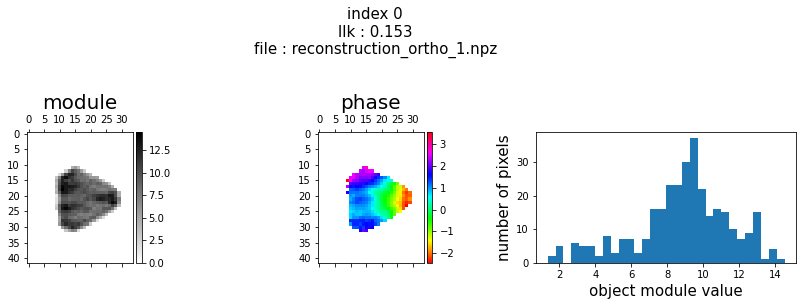

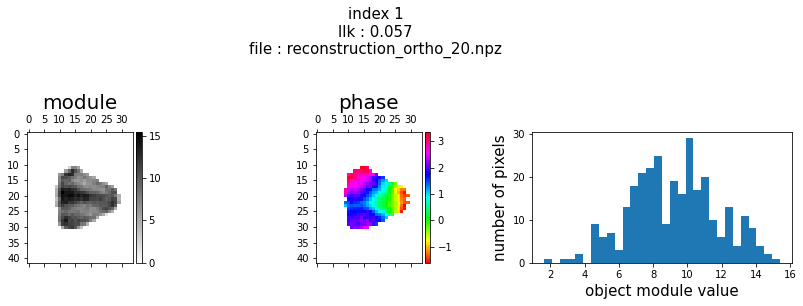

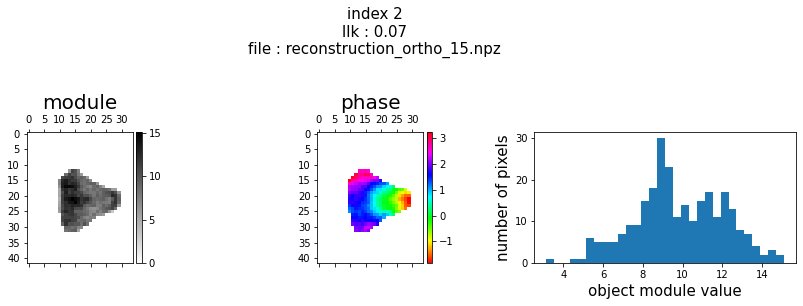

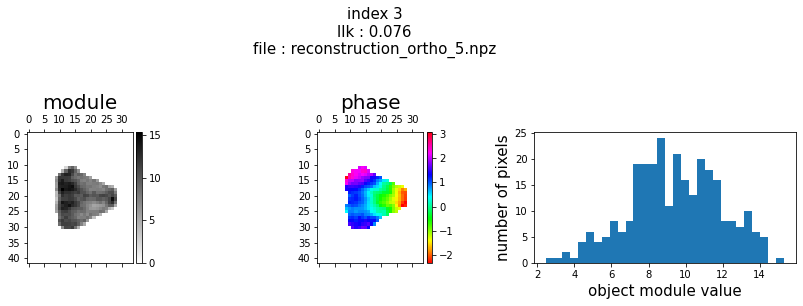

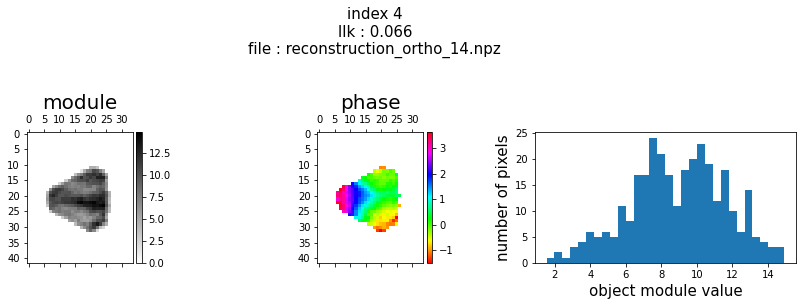

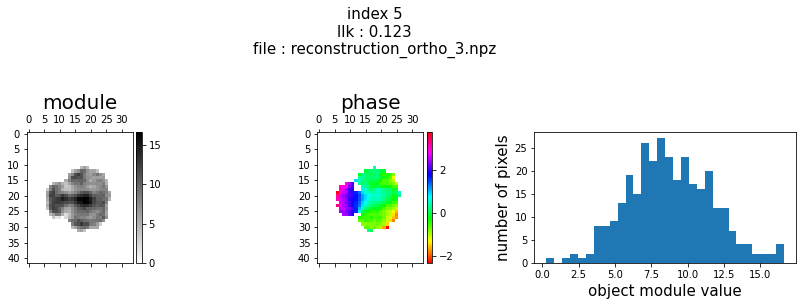

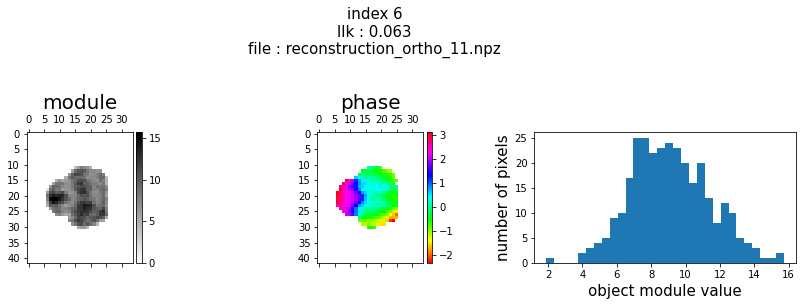

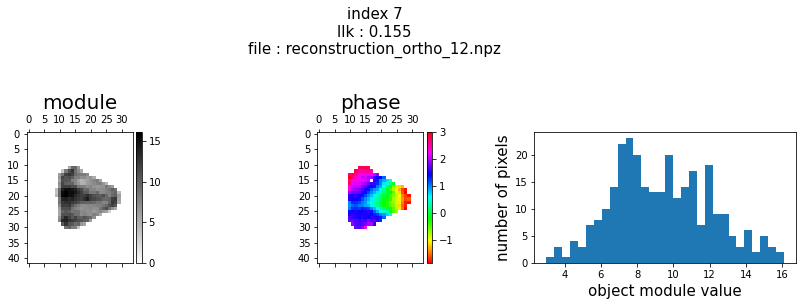

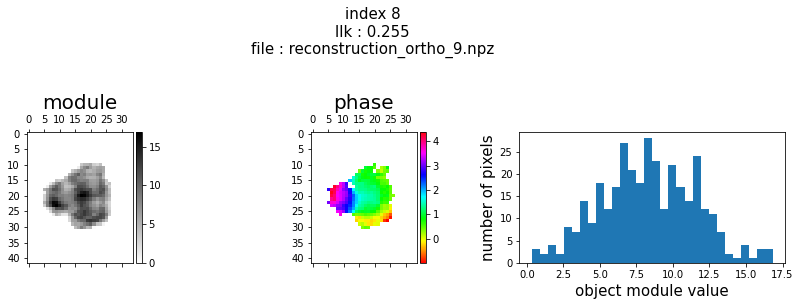

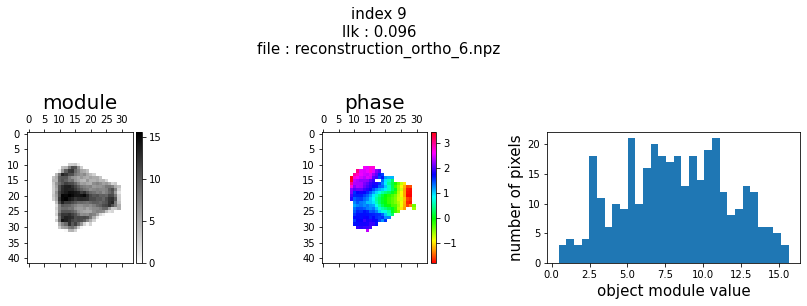

In [10]:
for n,obj in enumerate(obj_list[:10]):
    fig,ax = plt.subplots(1,3, figsize=(3*4,4))
    plot_object_module_phase_and_histogram_2d(obj, fig=fig, ax=ax)
    fig.suptitle('index {}\nllk : {}\nfile : {}'.format(n, round(llk_list[n],3), file_list[n].split('/')[-1]),
                 fontsize=15, y=1.05)
    fig.tight_layout()

oversampling ratio : [4.3 3.4]


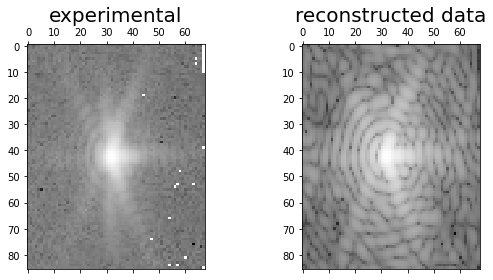

In [11]:
plot = False
plot_recon = True
remove_ramp = True
apodize_object = True
oversampling_check = True

index_best_recon = [0,1,3] 
conj_index = [1,1,1] #[1,1,1]


file_ref = np.load(file_list[index_best_recon[0]]) # reference file for scan infos
    
# obj_list_updated = center_object_list(obj_list[index_best_recon])

obj_list = []
for file in file_list[index_best_recon]:
    data = np.load(file)
    obj_list.append(data['obj'])
obj_list = np.array(obj_list)


obj_list_updated = center_object_list(obj_list)
# obj_list_updated = np.zeros(obj_list.shape, dtype='complex')
# for n in range(len(obj_list)):
#     obj_list_updated[n] = center_object(obj_list[n])

if conj_index is None:
    obj_list_updated = force_same_complex_conjugate_object_list(obj_list_updated) # Not working very well for 3D data
else:
    for n in range(len(obj_list_updated)):
        if conj_index[n] ==1 :
            obj_list_updated[n] = np.conj(obj_list_updated[n][::-1,::-1])
    
# for n in range(len(obj_list_updated)):
#     obj_list_updated[n] = center_object(obj_list_updated[n])
obj_list_updated = center_object_list(obj_list_updated)

if plot:
    plot_object_list_module_phase_2d(obj_list_updated)

if len(obj_list)>1:
    obj, weights = mode_decomposition(obj_list_updated, plot=plot)
else:
    obj = obj_list[0]
    weights = [1]
    
if plot or plot_recon:
    I_exp = np.load(str(np.load(get_npz_files(path_reconstruction)[0])['preprocessed_datapath']))['data'] # experimental intensity
    compare_reconstuction_to_real_data(I_exp, obj)

if apodize_object:
    obj = apodize(obj,
                window_type='blackman',
                plot=plot)

if remove_ramp:
    obj = remove_phase_ramp(obj, plot=plot)
    
if oversampling_check:
    print('oversampling ratio :', compute_oversampling_ratio(obj))

In [12]:
for n in range(len(weights)):
    print('mode {} : {} %'.format(n+1, round(1e2*weights[n], 2)))

mode 1 : 96.26 %
mode 2 : 1.98 %
mode 3 : 1.75 %


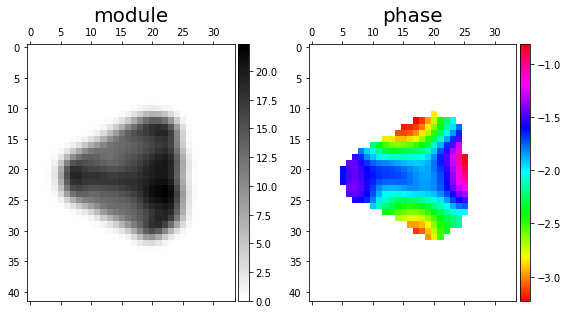

In [13]:
plot_object_module_phase_2d(obj)#,threshold_module=.3)

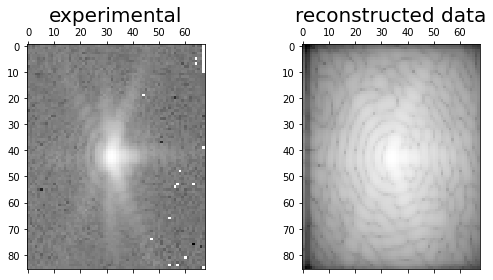

In [14]:
I_exp = np.load(str(np.load(get_npz_files(path_reconstruction)[0])['preprocessed_datapath']))['data'] # experimental intensity
compare_reconstuction_to_real_data(I_exp, obj)

# Make a roi

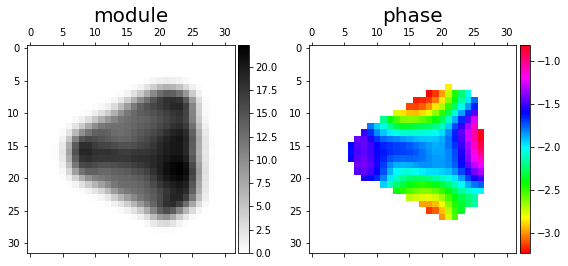

In [15]:
factor=.3

roi = automatic_object_roi(obj, factor=factor)

plot_object_module_phase_2d(obj[roi[0]:roi[1],roi[2]:roi[3]],crop=False)

In [16]:
obj = obj[roi[0]:roi[1],roi[2]:roi[3]]

# Displacement and gradient

In [17]:
voxel_sizes = np.zeros(2)
for n,key in enumerate(['qx', 'qy']):
    q = file_ref[key]
    range_q = np.nanmax(q) - np.nanmin(q)
    voxel_sizes[n] += 2.*np.pi/range_q
print('voxel_sizes (nm) : ', 1e-1*voxel_sizes)

voxel_sizes (nm) :  [53.85546874 51.24251077]


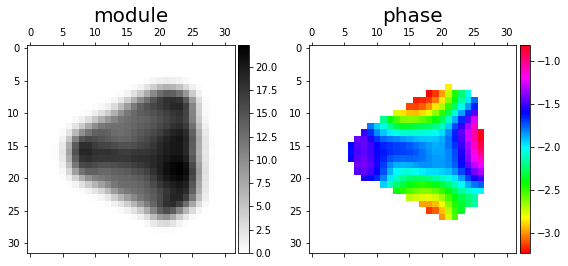

In [18]:
threshold_module = .3
plot_object_module_phase_2d(obj, threshold_module=threshold_module,crop=False)

/data/id01/inhouse/bellec/software/sharedipynb/gitlab/bcdi_eb/StrainTiltCalculation.py:26: RuntimeWarning: Mean of empty slice
  grad_n = np.nanmean([grad_n[tuple(slice1)], grad_n[tuple(slice2)]], axis=0)


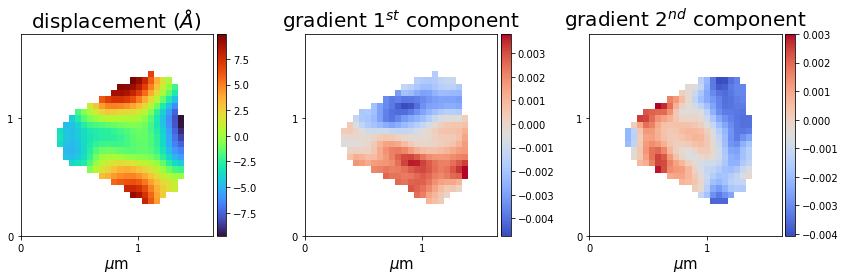

In [19]:
defect = False
qcen = file_ref['qcen']
displacement, grad =  displacement_and_gradient(obj, qcen,
                              voxel_sizes=voxel_sizes,
                              unwrap=True, crop=False, threshold_module=threshold_module,
                              use_negative_phase=True,
                              defect=defect, phase_shift=np.pi/2.,
                              plot=True)

# Strain, d-spacing, tilt

qcen in-plane orientation approximation error (degrees) : 1.7827226598207775
safety check (should be 0):  -5.50668721354392e-20


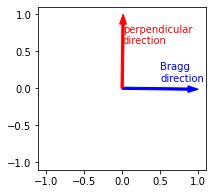

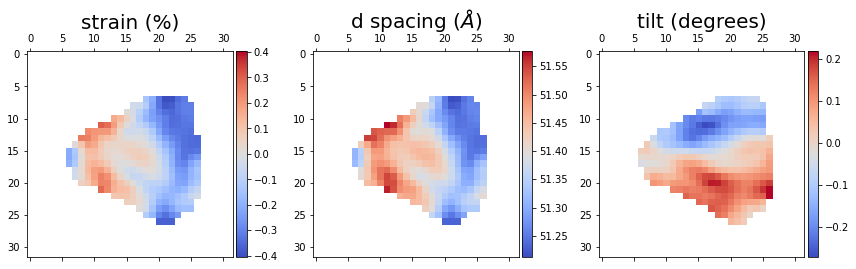

In [20]:
strain, d_spacing, tilt_angle, u_bragg, u_perp = compute_strain_tilt_2D(grad, qcen,
                   voxel_sizes=None,
                   angle_error_limit=10,
                   plot=True, verbose=True)

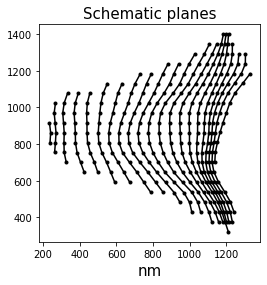

In [21]:
Bragg_planes_schematic_figure_2D(displacement, u_bragg, voxel_sizes,
                                    visual_factor=20,
                                    fig=None, ax=None, title=True,
                                    fw=4)

# Make a nice figure

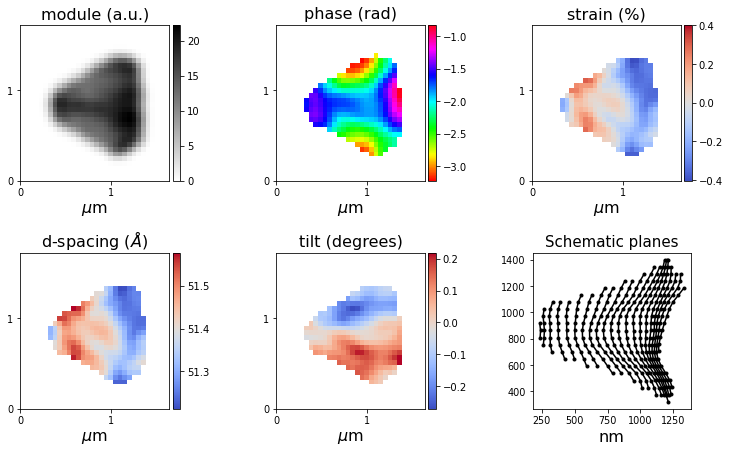

In [22]:
final_figure_2d(obj, strain, d_spacing, tilt_angle,
                displacement, u_bragg,
                 voxel_sizes, fw=3.2)

# Save final object

In [23]:
additional_dict = {}
additional_dict['displacement'] = displacement
additional_dict['tilt'] = tilt_angle
additional_dict['u_bragg'] = u_bragg
additional_dict['u_perp'] = u_perp


save_final_object(obj, strain, d_spacing, voxel_sizes,
                  file_ref, 
                  path_reconstruction,
                  additional_dict=additional_dict,
                  verbose=True)

final object saved at :  Reconstructions_CropAlgo/day2afternoon_h5file_day2afternoon_0024_scan3_ortho_rebin_rotremoved//final_obj/final_object.npz


# Remove bad reconstruction

In [26]:
delete_recon = False

if delete_recon:
    remove_bad_reconstructions(file_list,
                                   index_best_recon,
                                   verbose=True)